# Workshop 04: Component Reliability

**Solution.**

In this workshop, we will perform a reliability analysis of a structural problem: the reliability of a short column. In particular, we consider a column subjected to biaxial bending moments $M_1$ and $M_2$ and an axial force $P$ and is illustrated below. 

![column subjected to biaxial bending](./fig_column.png "Short column subjected to biaxial bending.")

Assuming an elastic perfectly plastic material with yield strength $y$, the failure of the column is defined by the limit state function:

$$ g(\mathbf{x}) = 1 - \frac{M_1}{s_1 Y} - \frac{M_2}{s_2 Y} - \left(\frac{P}{a Y}\right)^2 $$

where $ \mathbf{x} = \{M_1, M_2, P, Y\}^T $ represents the vector of random variables, $a=0.190 m^2$ is the cross-sectional area, $s_1=0.030 m^2$ and $s_2=0.015 m^2$ are the flexural moduli of the fully plastic column section. Assume $M_1$ and $M_2$ are correlated with a coefficient $\rho=0.5$. The distribution paramaters are given in the table below:

| Variable | Marginal distribution | Mean | c.o.v | 
| --- | --- | --- | --- |
| $M_1$ | Normal | 250 | 0.3 |
| $M_2$ | Normal | 125 | 0.3 |
| $P$ | Gumbel | 2500 | 0.2 |
| $Y$ | Weibull | 40000 | 0.1 |

**Note:** c.o.v. is _coefficient of variation_, $\sigma/\mu$. This is another way of defining describing the variance of a random variable, from which the standard deviation can also be found (given the mean is known). Don't confuse this with _covariance_ ($cov$ or $Cov$).


<div style="background-color:#ffa6a6; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"><p><b>This:</b> there was a typo in the original assignment. Rather than 40, the mean value of Y should have been 40000. This would not have caused problems with the final interpretation of the reliabiltiy methods, except that the mean value of the LSF would have indicated a <em>very</em> unsafe situation, and the distribution of Y defined using OpenTURNs would not have been consistent with the values in Task 2. See email and lecture clarification for further clarification.</p></div>


## Main Objective

The purpose of a component reliability problem is to compute the failure probability of the component. Once we have a limit state function, we can do this by solving the following integral:

$$
p_f = P[g<0] = F_g(g=0) = \int_{-\infty}^{0} f_g(x) \; \mathrm{d}X
$$

The challenge is that finding a the PDF of $g_X(x)$ is not trivial.

The purpose of this assignment is to illustrate two commonly used algorithms for dealing with this. First we will use a very approximate method (one you are already familiar with in MUDE), along with a few exercises to help understand the component reliability problem. Then we use OpenTURNs to apply two algorithms: Monte Carlo Simulation and FORM (First-Order Reliability Analysis).

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)
import sympy as sp

## Task 1: Getting Started

Let's take care of a few initial tasks to warm up and get familiar with the problem. The first steps consist in assigning the problem to python variables. First the deterministic parameters, then some of the "key ingredients" of our reliability problem (the random variables, multivariate distribution and the limit-state function).

_Note that the multivariate distribution will be defined later in OpenTURNs directly. For now we will only deal with the mean and variance marginal distributions (which implies statistical independence between all variables)._

In [2]:
a = 0.190
s1 = 0.030
s2 = 0.015

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 1.1:</b>
Define the mean and variance of the marginal distributions.
</p>
</div>

In [3]:
mean_M1 = 250
std_M1 = 0.3*mean_M1
variance_M1 = std_M1**2
mean_M2 = 125
std_M2 = 0.3*mean_M2
variance_M2 = std_M2**2
mean_P = 2500
std_P = 0.2*mean_P
variance_P = std_P**2
mean_Y = 40000
std_Y = 0.1*mean_Y
variance_Y = std_Y**2

mean_vector = [mean_M1, mean_M2, mean_P, mean_Y]
std_vector = [std_M1, std_M2, std_P, std_Y]

We would like to define our limit-state function (LSF) using a Python function. Becaues the function will be called many times and it is inefficient computationally to use a for loop, the LSF should be vectorized, which means that the function allows all the points in a sample to be evaluated at once without making a for loop : **arguments and returns can be lists**. 

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 1.2:</b>
Define the limit-state function and confirm that the function has been vectorized.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution start</b>
</p>
</div>

The solution is in the code cell below.

In [4]:
def myLSF(x):
    ''' 
    Vectorized limit-state function.

    Arguments:
    x: vector. x=[m1, m2, p, y].

    Returns: a list with the value of g(x).
    '''
    g = [1 - x[0]/(s1*x[3]) - x[1]/(s2*x[3]) - (x[2]/(a*x[3]))**2]
    return g

x = mean_vector
g = myLSF(x)
assert type(g) == list
assert len(g) == len(x)/4

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution end</b>
</p>
</div>

## Task 2: Initial non-deterministic approaches

Now we would like to gain some understanding of the component we wish to evaluate. Let's begin by evaluating whether it is stable in its current condition.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 2.1:</b>
Evaluate the limit state function at the mean values of the random variables and determine whether or not you think it is stable.
</p>
</div>

In [5]:
x = mean_vector
g = myLSF(x)
print(f'The limit state function at x={x} is {g[0]:.2e}')

The limit state function at x=[250, 125, 2500, 40000] is 4.75e-01


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution</b>
The value is much less than 0, indicated that the mean values of the variables produce a failed state. That is pretty bad!
</p>
</div>

We can also define the function using `Sympy`!

In [6]:
m1, m2, p, y = sp.symbols('m1 m2 p y')
g_sympy = 1 - m1/(s1*y) - m2/(s2*y) - (p/(a*y))**2
g_lambdified = sp.lambdify((m1, m2, p, y), g_sympy, modules='numpy')
g_mean = g_lambdified(250, 125, 2500, 40000)
print(f'The limit state function at x={mean_vector} is {g_mean:.5e}')

The limit state function at x=[250, 125, 2500, 40000] is 4.75127e-01


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution end</b>
</p>
</div>

### Distribution of the Linearized Limit State Function

Now we will try to solve for the failure probability in a simple way. Recall from MUDE that using Taylor's Series we can approximate the expectation and variance of a function of random variables (see [error propagation page](https://mude.citg.tudelft.nl/book/propagation_uncertainty/01_ErrorPropagation.html)). We can use this approach to approximate the failure probability as follows:
- linearize the limit state function, $\hat{g}_X(x) \approx g_X(x)$ (only the first-order term is needed; the first partial derivative)
- compute the expectation and variance of the linearized function, $\mathbb{E}[\hat{g}_X(x)]$ and $\sigma_{\hat{g}_X(x)}^2$
- evaluate the probability of failure as $\mathrm{P}[\hat{g}_X(x)<0]$, assuming $\hat{g}_X(x)$ follows a Normal distribution

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 2.2:</b>
Approximate the expectation and variance of the limit state function, then solve for the failure probability using the approach outlined above.

<em>Hint: it would be easiest to write this out by hand, and you you will probably also find it useful to make a table with rows for the random variables and columns for various steps in the calculation.</em> 
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution start</b>
<br>
Derivatives were found by hand (not shown here in entirety), and Sympy was used to check the calculations (see assert statements).
</p>
</div>



The expectation of the function can be found as follows:

$$
\mathbb{E}\big[\hat{g}_X(x)\big] = \mathbb{E}\Bigg[g(\mu_X) + \sum_i \bigg[(X - \mu_{X_i})\frac{\partial g}{\partial X_i} \bigg|_{\mu_X} \bigg]\Bigg]
$$

Where $i$ denotes each random variable. Notice that if we evaluate the expectation of the linearized function the term $(X - \mu_{X_i})$ becomes 0; this is why the expectation of the linearized function is simply the function evaluated at the mean point of each random variable.

The variance of the linearized function is:

$$
\sigma_{\hat{g}_X(x)}^2
= \sum_i \Bigg[\sigma_{X_i}^2 \bigg(\frac{\partial g}{\partial X_i} \bigg|_{\mu_X}\bigg)^2\Bigg]
$$

Thus, the variance is simply the sum of the product of variances with the corresponding partial derivative, evaluated at the mean (the expansion point).

Partial derivatives are:

$$
\frac{\partial g}{\partial M_1} = -\frac{1}{s_1 Y}
$$

$$
\frac{\partial g}{\partial M_2} = -\frac{1}{s_2 Y}
$$

$$
\frac{\partial g}{\partial P} = -\frac{2P}{aY^2}
$$

$$
\frac{\partial g}{\partial Y} = \frac{M_1}{s_1 Y^2} + \frac{M_2}{s_2 Y^2} + \frac{2P^2}{a Y^3}
$$

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Note that here we ignore the correlation/dependence. If included, there would be another term in the variance equation (only one term, as there is only dependence between 2 of the 4 random variables). Including this would have a minimal effect on the calculation, as confirmed by the quantitative effect of depednence for MCS and FORM, below.</p></div>

In [32]:
dg_dm1 = sp.diff(g_sympy, m1)
dg_dm2 = sp.diff(g_sympy, m2)
dg_dp = sp.diff(g_sympy, p)
dg_dy = sp.diff(g_sympy, y)


dg_dm1_lambdified = sp.lambdify((m1, m2, p, y),
                                dg_dm1, modules='numpy')
dg_dm2_lambdified = sp.lambdify((m1, m2, p, y),
                                dg_dm2, modules='numpy')
dg_dp_lambdified = sp.lambdify((m1, m2, p, y),
                               dg_dp, modules='numpy')
dg_dy_lambdified = sp.lambdify((m1, m2, p, y),
                               dg_dy, modules='numpy')

assert np.isclose(dg_dm1_lambdified(250, 125, 2500, 40000),
                  -1/(0.03*40000))
assert np.isclose(dg_dm2_lambdified(250, 125, 2500, 40000),
                  -1/(0.015*40000))
assert np.isclose(dg_dp_lambdified(250, 125, 2500, 40000),
                  -2*2500/(.190*40000)**2)
assert np.isclose(dg_dy_lambdified(250, 125, 2500, 40000),
                  250/(.03*40000**2) + 125/(0.015*40000**2)
                  + 2*2500**2/(.190**2*40000**3))

print(f'dg/dm1 = {dg_dm1_lambdified(250, 125, 2500, 40000):.2e}')
print(f'dg/dm2 = {dg_dm2_lambdified(250, 125, 2500, 40000):.2e}')
print(f'dg/dp = {dg_dp_lambdified(250, 125, 2500, 40000):.2e}')
print(f'dg/dy = {dg_dy_lambdified(250, 125, 2500, 40000):.2e}')

var_m1 = variance_M1
var_m2 = variance_M2
var_p = variance_P
var_y = variance_Y

#print the variance for each variable
print(f'Variance of M1: {var_m1:.2e}')
print(f'Variance of M2: {var_m2:.2e}')
print(f'Variance of P: {var_p:.2e}')
print(f'Variance of Y: {var_y:.2e}')

g_var_i = [dg_dm1_lambdified(mean_M1, mean_M2, mean_P, mean_Y)**2 * var_m1,
           dg_dm2_lambdified(mean_M1, mean_M2, mean_P, mean_Y)**2 * var_m2,
           dg_dp_lambdified(mean_M1, mean_M2, mean_P, mean_Y)**2 * var_p,
           dg_dy_lambdified(mean_M1, mean_M2, mean_P, mean_Y)**2 * var_y]

print('The contribution of each term to the variance is:')
[print(f'  {i:.3e}') for i in g_var_i]

g_var = sum(g_var_i)

print(f'The variance of the limit state function is {g_var:.2e}')
g_std = np.sqrt(g_var)
print(f'The sted dev of the limit state function is {g_std:.2e}')


dg/dm1 = -8.33e-04
dg/dm2 = -1.67e-03
dg/dp = -8.66e-05
dg/dy = 1.58e-05
Variance of M1: 5.62e+03
Variance of M2: 1.41e+03
Variance of P: 2.50e+05
Variance of Y: 1.60e+07
The contribution of each term to the variance is:)
  3.906e-03
  3.906e-03
  1.873e-03
  4.008e-03
The variance of the limit state function is 1.37e-02
The sted dev of the limit state function is 1.17e-01


In [8]:
g_linear = stats.norm(loc=g_mean, scale=g_std)
print(f'Probability of failure with linear model: {g_linear.cdf(0):.2e}')

Probability of failure with linear model: 2.45e-05


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution end</b>
</p>
</div>

## Task 3: Set Up OpenTURNS

As mentioned in the OpenTURNS tutorial, we will be using the `PythonFunction` class to define our LSF, which should be vectorized. Luckily you already did that above! Now we need to define the random variables (distributions).

You probably observed that the information above contains each distribution's first and second moments (mean and standard deviation), which for normal distributions is enough to define them in OpenTURNS. However, the Gumbel and Weibull distributions have different distributions parameters, which are defined in OpenTURNS documentation ([Gumbel](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.Gumbel.html) and [Weibull](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.WeibullMin.html)). In the context of this workshop, we compute the distribution parameters for you to focus on the analyses; it is however a good exercise to do it yourself later.

The distribution parameters for the Gumbel distribution $X \sim Gumbel(\beta, \gamma)$, as presented in the OpenTURNs documentation, are defined such that:

$$ \mathbb{E}[X] = \gamma + \gamma_e \beta $$
$$ \sigma[X] = \frac{\pi \beta}{\sqrt{6}} $$

In [9]:
beta = (np.sqrt(6)*2500*0.2)/np.pi
gamma = 2500 - np.euler_gamma*beta

Likewise, the distribution parameters for the Weibull distribution $X \sim Weibull(\beta, \alpha)$ are defined such that:

$ \mathbb{E}[X] = \beta \Gamma \left(1 + \frac{1}{\alpha} \right) $

$ \sigma [X] = \beta  \sqrt{\left(\Gamma \left(1+\frac{2}{\alpha}\right) - \Gamma^2 \left(1 + \frac{1}{\alpha} \right)\right)} $

By solving the system of equations, we obtain $\beta = 41700$ and $\alpha = 12.2$.

Now that the parameters are known, we can finally create random variables objects using OpenTURNS.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 3.1:</b>
Execute the cell below to define the marginal distributions of the random variables using <code>OpenTURNs</code> objects. Evaluate the attribues and methods of the objects to get familiar with the distributions.
</p>
</div>

In [10]:
M1 = ot.Normal(250, 0.3*250)
M2 = ot.Normal(125, 0.3*125)
P = ot.Gumbel(beta, gamma)
Y = ot.WeibullMin(41700, 12.2)

In [11]:
print('The mean and standard deviation of Y are ',
      f'{Y.getMean()[0]:.2e} and {Y.getStandardDeviation()[0]:.2e}')

The mean and standard deviation of Y are  4.00e+04 and 3.98e+03


Here is an example how you can easily visualize the PDF (there are other plotting options as well, for example, see [here](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.WeibullMin.html)):

c:\Users\rlanzafame\code\github-CIE42X0-PD-24\WS04-dev\.venv\Lib\site-packages\openturns\viewer.py:684: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self._fig.show(**kwargs)


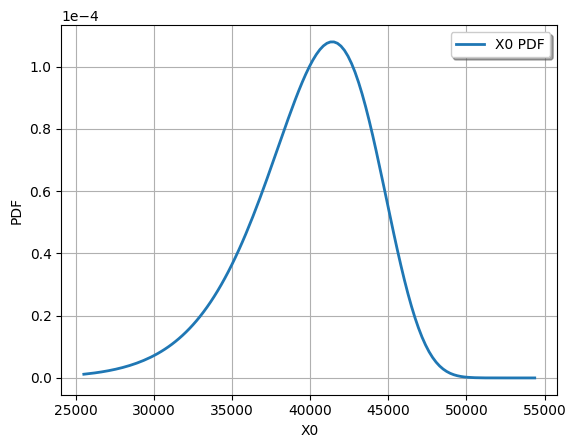

In [12]:
graph = Y.drawPDF()
view = viewer.View(graph)
view.show()

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Note that the central moments of the distribution are around 40000; this is why it was obvious that there was a typo in the original assignment. It also illustrates why it is important to visualize the distributions that you are using: to <em>verify</em> that they are correct!</p></div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 3.2:</b>
Read the code cell below and identify the "key ingredients" as implemented for OpenTURNs. Identify the correlation matrix and assign the correlation coefficient defined above to the proper combination of random variables.
</p>
</div>
<br>
<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution:</b><br>
The solution is in the code cell below. The main ingredients are the multivariate distribution (in this case the multivariate Gaussian, <code>NormalCopula</code>), the LSF (<code>myfunction</code>) and the region of interest (<code>failureevent</code>). The random variables have been defined previously and algorithm for finding failure probability is defined next (either MCS or FORM).
<br><br>As you can see we specify multivariate normal, which requires only a matrix of correlation coefficients. When it comes time to include correlation, only the correlation matrix must be modified. Since the first line generates a correlation matrix of independent random variables by default, and only the first two random variables are correlated, you simply need to add the coefficient to two indices (presented in a solution box below). Remember the matrix is symmetric and diagonal in the case of independence between all variables.
</div>

In [13]:
R = ot.CorrelationMatrix(4)
multinorm_copula = ot.NormalCopula(R)

inputDistribution = ot.ComposedDistribution((M1, M2, P, Y), multinorm_copula)
inputDistribution.setDescription(["M1", "M2", "P", "Y"])
inputRandomVector = ot.RandomVector(inputDistribution)

myfunction = ot.PythonFunction(4, 1, myLSF)

# Vector obtained by applying limit state function to X1 and X2
outputvector = ot.CompositeRandomVector(myfunction, inputRandomVector)

# Define failure event: here when the limit state function takes negative values
failureevent = ot.ThresholdEvent(outputvector, ot.Less(), 0)
failureevent.setName('LSF inferior to 0')

## Task 4: Algorithm 1, MCS

OpenTURNS also allows users to perform Monte Carlo Simulations. This algorithm is simple, as we only need to produce a sample of $g(\mathbf{x})$ and count the negative realizations.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 4:</b>
Complete the code below to evaluate the failure probability.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution:</b> you were supposed to have defined the last two lines on your own, but we forgot to remove that from that assignment. Make sure you realize how simple MCS is once you obtain a random sample from the multivariate distribution!
</p>
</div>



In [14]:
montecarlosize = 10000
outputSample = outputvector.getSample(montecarlosize)

number_failures = sum(i < 0 for i in np.array(outputSample))[0]
pf_mc = number_failures/montecarlosize

## Task 5: Algorithm 2, FORM

The First-Order Reliability Method (FORM) uses a linear approximation of the limit state function to evaluate failure probability. It is very similar to the method applied above, except the _expansion point of Taylor Series_ is different: it is the solution of an optimization problem, and is called the _design point_. The _design point_ is a vector of values, one for each random variable, and is denoted with symbol $x^*$. We will see what that is later on in the assignment, as well as how the probability is different. For now...

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 5.1:</b>
Read the code below and identify the key ingredients, along with some steps that the algorithm apparently takes. Then execute the code cell to evaluate the failure probability.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution:</b> the only ingredient defined here is the algorithm, FORM. You don't have to understand the details of every attribute that is being set, but you should recognize that the reliabiltiy algorithm uses an optimization algorithm (<code>optimAlgo</code>) which has a few parameters to stop the iterative solution approach. Then the FORM analysis is set up and executed using an object-oriented approach (running the model is method <code>run()</code> of the instance of the class <code>FORM</code>).
</p>
</div>



In [15]:
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

algo = ot.FORM(optimAlgo, failureevent, inputDistribution.getMean())
algo.run()
result = algo.getResult()

Print results in a separate cell from the analysis:

In [16]:
pf = result.getEventProbability()
x_star = result.getPhysicalSpaceDesignPoint()

print('FORM result, pf = {:.4f}'.format(pf))
print()
print('The design point x_star consists of the following values:')
for name, value in zip(inputDistribution.getDescription(), x_star):
    print(f'  {name:2s} = {value:.2e} (or {value:g})')
print()
print('For reference, the mean and std dev of each RV are:')
for name, value, std in zip(inputDistribution.getDescription(),
                            inputDistribution.getMean(),
                            inputDistribution.getStandardDeviation()):
    print(f'  {name:2s}: mean = {value:6g}, std = {std:6g}')

FORM result, pf = 0.0033

The design point x_star consists of the following values:
  M1 = 3.03e+02 (or 302.54)
  M2 = 1.51e+02 (or 151.27)
  P  = 3.02e+03 (or 3017.01)
  Y  = 2.89e+04 (or 28895.4)

For reference, the mean and std dev of each RV are:
  M1: mean =    250, std =     75
  M2: mean =    125, std =   37.5
  P : mean =   2500, std =    500
  Y : mean =  39985, std = 3983.97


As mentioned, the design point is the expansion point for the linearized limit-state function. Checking the LSF value at the design point:

In [23]:
print(f'The LSF evaluated at the design point is: ',
      f'{myLSF(x_star)[0]:.2e}')

The LSF evaluated at the design point is:  1.00e-10


<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>This confirms that the design point is <em>on</em> the limit state (illustrated in the figures below, as well). The value of 1e-10 is also not a coincidence: it is the tolerance from the FORM algorithm, which used that value as a stop criteria for the optimization algorithm.</p></div>

We can also recompute the gradient at the expansion point to see how it has changed, relative to the case with the expansion point as the mean values, $\mu_X$.

In [61]:
g_var_i = [dg_dm1_lambdified(*x_star)**2 * var_m1,
           dg_dm2_lambdified(*x_star)**2 * var_m2,
           dg_dp_lambdified(*x_star)**2 * var_p,
           dg_dy_lambdified(*x_star)**2 * var_y]

print('The contribution of each term to the variance is:')
[print(f'  {i:.3e}') for i in g_var_i]

g_var = sum(g_var_i)

print(f'The variance of the LSF at x_star is {g_var:.2e}')
g_std = np.sqrt(g_var)
print(f'The sted dev of the LSF at x_star is {g_std:.2e}')

The contribution of each term to the variance is:
  7.486e-03
  7.486e-03
  1.002e-02
  3.248e-02
The variance of the LSF at x_star is 5.75e-02
The sted dev of the LSF at x_star is 2.40e-01


Note that OpenTURNS provides another way to compute gradients of the limit state function (by default it uses as central finite difference approximation).

In [102]:
g_grad_ot = myfunction.gradient(x_star)

g_grad_i = [dg_dm1_lambdified(*x_star),
            dg_dm2_lambdified(*x_star),
            dg_dp_lambdified(*x_star),
            dg_dy_lambdified(*x_star)]

print('Gradient computed by:\n     Sympy        OpenTURNs')
[print(f'  {i:10.3e}     {j:10.3e}') for i, j in zip(g_grad_i, np.array(g_grad_ot).transpose()[0])]

Gradient computed by:
     Sympy        OpenTURNs
  -1.154e-03     -1.154e-03
  -2.307e-03     -2.307e-03
  -2.002e-04     -2.002e-04
   4.506e-05      4.506e-05


[None, None, None, None]

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 5.2:</b>
Consider the design point above, and make a note about how these values (the linearization expansion point) differ from the mean of each random variable.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution:</b> first, note that for all random variables the design point is different from the mean value. Second, note that for Y the value is lower, whereas for the rest the value is higher. This is because Y is a "resistance" variable, whereas the others are loads. It shows that the design point defines a combination of variable values that is <em>more representative of a failure condition</em> (in fact, it is the "most likely" failure condition---as we will discuss later). The key takeaway at this point is to recognize that the expansion point that defines the linearized limit-state function is more suitable to the failed state of the component than an expansion point at the mean values. One could also say that this allows the function to be more representative to the "tails" of the distributions, where component failure actually occurs.
</p>
</div>



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 5.3:</b>
Compare the probabilities computed from FORM and MCS (you will use this in your report).
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    <b>Solution/note:</b> here we print the values of both methods, for use in the Report
</p>
</div>

In [17]:
print("The failure probability computed with FORM (OpenTURNS) is: ",
      "{:.4g}".format(pf))
print("The failure probability computed with MCS (OpenTURNS) is: ",
      "{:.4g}".format(pf_mc))
print(f'Probability of failure with linear model: {g_linear.cdf(0):.2e}')

The failure probability computed with FORM (OpenTURNS) is:  0.003337
The failure probability computed with MCS (OpenTURNS) is:  0.0038
Probability of failure with linear model: 2.45e-05


### Task 6: Rerun Analysis to Check Dependence

Recall in the problem specification that there is correlation between two of the random variables. Let's check the quantitative effect of including that in our analysis.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 6:</b>
Return to the code above, identify the correlation matrix and assign the correlation coefficient defined above to the proper combination of random variables.
</p>
</div>
<br>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution start</b>
</p>
</div>

The relevant piece of code and corresponding results are presented below. As you can see, we specify a multivariate Gaussian distribution, which requires only a matrix of correlation coefficients. Since the first line of the original code generates a correlation matrix of independent random variables by default, and only the first two random variables are correlated, you simply need to add the coefficient to two indices. Remember the matrix is symmetric and diagonal in the case of independence between all variables.

For the case _without_ correlation, $\rho=0$ and the code here:
```
R = ot.CorrelationMatrix(4)   
multinorm_copula = ot.NormalCopula(R)
```
produces results:
```
The failure probability computed with FORM (OpenTURNS) is:  0.003337
The failure probability computed with MCS (OpenTURNS) is:  0.0051*
```

**Note:** the values computed my MCS will vary and probably different from yours, as they are based on random samples.

For the case _with_ correlation, $\rho=0.5$ and the code here:
```
R = ot.CorrelationMatrix(4)   
R[0,1] = 0.5
R[1,0] = 0.5
multinorm_copula = ot.NormalCopula(R)
```
produces results:
```
The failure probability computed with FORM (OpenTURNS) is:  0.004364
The failure probability computed with MCS (OpenTURNS) is:  0.007*
```

Remember, the linear model produced the following result (which can only be compared to the independent case):

```
Probability of failure with linear model: 2.45e-05
```

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution end</b>
</p>
</div>

## Task 7: Graphical Interpretation

The difference between the two probabilities above was expected because FORM uses a linear approximation of the limit-state function. It is easiest to understand this if we look at bivariate plots that compare two random variables at a time, along with the limit-state function. This also makes it easier to understand and interpret the design point, which is unique for the FORM algorithm. 

Running the code below will create two plots. Since $M_2$ and $Y$ have the strongest contributions to the failure probability, we choose to position ourselves in that plane first.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 7.1:</b>
Read the code to understand what is happening. Then look at the figure and read the interpretation points provided in the box below the figure.
</p>
</div>


In [18]:
def f_m2(m1, p, y):
    ''' Computes m2 given m1, p and y. '''
    return s2*y - m1*s2/s1 - (s2*p**2) /(y*a**2)

def f_m1(m2, p, y):
    ''' Computes m1 given m2, p and y. '''
    return s1*y - m2*s1/s2 - (s1*p**2) /(y*a**2)



y_sample = np.linspace(10000, 50000, 200)
m2_sample = [f_m2(x_star[0], x_star[2], k) for k in y_sample]     # For now, take (Y, M2) plane

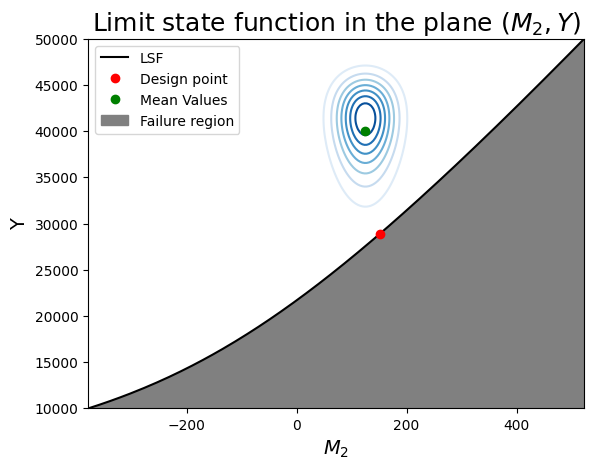

In [19]:
f, ax = plt.subplots(1)

ax.plot(m2_sample, y_sample, label="LSF", color="k")
# Contour plot
X_grid,Y_grid = np.meshgrid(m2_sample,y_sample)
pdf = np.zeros(X_grid.shape)
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
            # This is correct, but only works when ALL RV's are independent!
            # pdf[i,j] = M2.computePDF(X_grid[i,j])*Y.computePDF(Y_grid[i,j])
            pdf[i,j] = inputDistribution.computePDF([x_star[0], X_grid[i,j], x_star[2], Y_grid[i,j]])
ax.contour(X_grid, Y_grid, pdf, levels=8, cmap=cm.Blues)

ax.set_xlabel(r"$M_2$", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.plot(x_star[1], x_star[3], 'ro', label="Design point")
ax.plot(mean_vector[1], mean_vector[3], 'go', label="Mean Values")
ylim = ax.get_ylim()
ax.fill_between(m2_sample, ylim[0], y_sample, color="grey", label="Failure region")
ax.set_title(r"Limit state function in the plane $(M_2, Y)$", fontsize=18)
ax.legend();

<div style="background-color:#C8FFFF; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
From the figure above, note:
<ul>
    <li>the limit-sate function is indeed concave toward the mode of the joint distribution (the "mode" is the origin in the u-space).</li>
    <li>Since the variables are independent, the contours are symmetric around each axis.</li>
    <li>We can see that the design point is the point on the limit-state surface that is closes to the center of the contours.</li>
    <li>Imagine how changing the mean or variance of the random variables would change the design point.</li>
</ul>
</div>


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 7.2:</b>
Now we will do the same thing, but focus on a different combination of variables. Identify the variable that are included in this figure. Then look at the figure, compare with the previous one and read the interpretation points provided in the box below it.
</p>
</div>

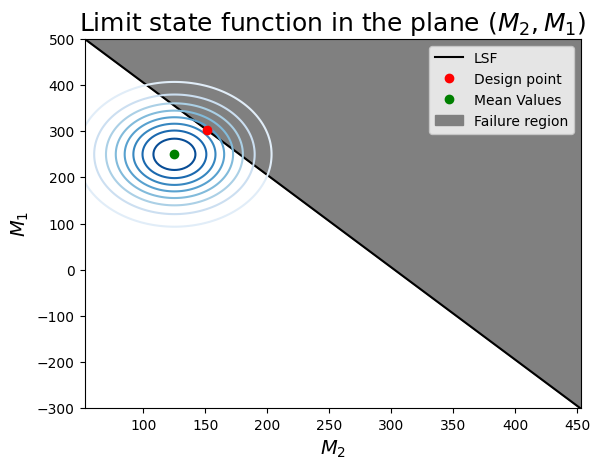

In [20]:
m1_sample = np.linspace(-300, 500, 200)
m2_sample = [f_m2(k, x_star[2], x_star[3]) for k in m1_sample]

f, ax = plt.subplots(1)

ax.plot(m2_sample, m1_sample, label="LSF", color="k")
# Contour plot
X_grid,Y_grid = np.meshgrid(m2_sample,m1_sample)
pdf = np.zeros(X_grid.shape)
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
            # This is correct, but only works when ALL RV's are independent!
            # pdf[i,j] = M2.computePDF(X_grid[i,j])*Y.computePDF(Y_grid[i,j])
            pdf[i,j] = inputDistribution.computePDF([Y_grid[i,j], X_grid[i,j], x_star[2], x_star[3]])
ax.contour(X_grid, Y_grid, pdf, levels=8, cmap=cm.Blues)

ax.set_xlabel(r"$M_2$", fontsize=14)
ax.set_ylabel(r"$M_1$", fontsize=14)
ax.plot(x_star[1], x_star[0], 'ro', label="Design point")    # Delete x_star[1] and x_star[3] for students
ax.plot(mean_vector[1], mean_vector[0], 'go', label="Mean Values")
ylim = ax.get_ylim()
ax.fill_between(m2_sample, m1_sample, ylim[1], color="grey", label="Failure region")
ax.set_title(r"Limit state function in the plane $(M_2, M_1)$", fontsize=18)
ax.legend();

<div style="background-color:#C8FFFF; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
From the figure above, note:
<ul>
    <li>this combination of variables has a more linear limit-state surface (this is not general for the entire problem: we can only visualize 2 variables at a time!)</li>
    <li>you can identify the correlation between $M_1$ and $M_2$ as the inclined axis of the elliptical contours of probability density.</li>
    <li>The design point seems to be correct: it is the highest density on the limit-state surface.</li>
</ul>
</div>


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>End of notebook:</b>
once you have completed all tasks, test your understanding and interpretation by answering the questions in <code>Report.md</code>.
</p>
</div>